In [78]:
from dask import dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from functools import reduce
import seaborn as sns
from sklearn import preprocessing
from pandas import DataFrame
from pandas import concat
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from random import randrange

from random import seed
from random import random
from matplotlib import pyplot
import pandas
from pandas.plotting import autocorrelation_plot
from keras import Model
from keras.layers import GRU, Dense, Input, Dropout, LSTM
%matplotlib inline

from numpy.random import seed as np_seed
from tensorflow import set_random_seed
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback

from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

SEED = 42

seed(SEED)
np_seed(SEED)
set_random_seed(SEED)


path = '../data/'




In [23]:
df_sds011 = dd.read_csv(path + 'processed*sds011*').compute()
df_dht22 = dd.read_csv(path + 'processed*dht22*').compute()

df_sds011['timestamp'] = pd.to_datetime(df_sds011['timestamp'], format='%Y-%m-%dT%H:%M:%S')
df_dht22['timestamp'] = pd.to_datetime(df_dht22['timestamp'], format='%Y-%m-%dT%H:%M:%S')


#Problems when remove index category because of multi index
#df_sds011['location'] = df_sds011['location'].astype('category')
#df_dht22['location'] = df_dht22['location'].astype('category')

df_sds011 = df_sds011.set_index(['location', 'timestamp'])
df_dht22 = df_dht22.set_index(['location', 'timestamp'])

df_sds011 = df_sds011.sort_index()
df_dht22 = df_dht22.sort_index()

df_sds011 = df_sds011[['P1', 'P2']]
df_dht22 = df_dht22[['temperature', 'humidity']]

In [138]:
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64


In [139]:
df_sds011.describe()

,P1,P2
count,739843.000000,739843.000000
mean,26.867225,15.717884
std,31.916156,17.506098
min,0.000000,0.000000
25%,6.920000,3.800000
50%,14.130000,8.330000
75%,35.530000,21.200000
max,1999.900000,564.800000


In [140]:
df_dht22.describe()

,temperature,humidity
count,743179.000000,743179.000000
mean,12.650757,80.143466
std,9.213619,23.280162
min,-10.400000,5.200000
25%,5.500000,62.600000
50%,10.800000,91.300000
75%,19.200000,99.900000
max,57.800000,99.900000


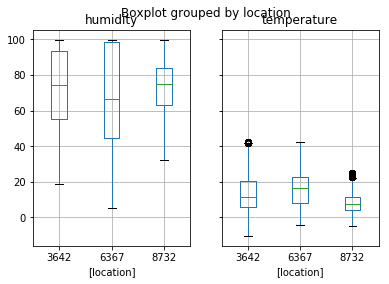

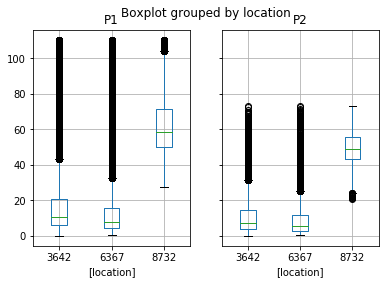

In [151]:
_ = df_dht22.boxplot(by='location')
_ = df_sds011.boxplot(by='location')

location
3642    AxesSubplot(0.125,0.125;0.775x0.755)
6367    AxesSubplot(0.125,0.125;0.775x0.755)
8732    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

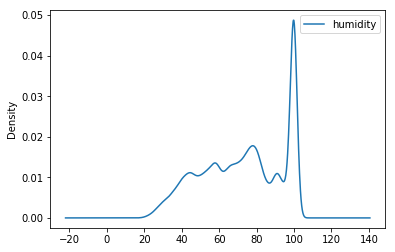

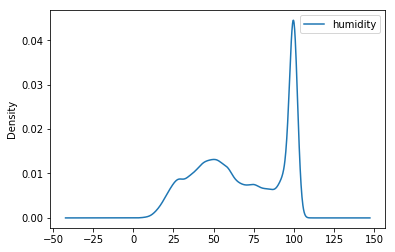

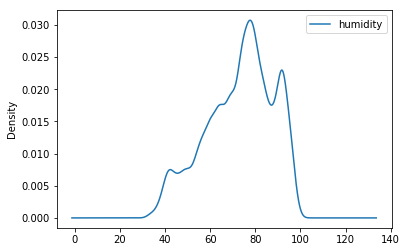

In [148]:
df_dht22.groupby(level=0)[['humidity']].plot(kind='kde')

In [ ]:
df_sds011.groupby(level=0).plot(kind='kde')

In [ ]:
df_dht22.groupby(level=0).plot( kind='kde')

# Drop unnecessary  data 

In [24]:
df_sds011 = df_sds011.drop([3123, 10574], level=0)
df_dht22 = df_dht22.drop([3123, 10574], level=0)
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64


# Outliers

In [25]:
def remove_outlier(df):
    res = df[np.abs(df - df.mean()) <= (3*df.std())]
    #print(res.groupby(level=0).count())
    return res.dropna()


print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = remove_outlier(df_sds011)
df_dht22 = remove_outlier(df_dht22)

print(df_sds011.shape)
print(df_dht22.shape)

print('NaNs')
print(df_sds011.isnull().sum())
print(df_dht22.isnull().sum())

(475734, 2)
(476184, 2)
(463074, 2)
(472139, 2)
NaNs
P1    0
P2    0
dtype: int64
temperature    0
humidity       0
dtype: int64


In [132]:
df_sds011.describe()

(472139, 2)

In [135]:
df_dht22.describe()

,temperature,humidity
count,472139.000000,472139.000000
mean,13.466294,70.984304
std,9.129547,22.935422
min,-10.400000,5.200000
25%,6.100000,52.800000
50%,11.900000,73.200000
75%,20.500000,93.000000
max,42.500000,99.900000


In [ ]:
#_ = df_dht22.boxplot(by='location')
#_ = df_sds011.boxplot(by='location')

In [ ]:
df_sds011.groupby(level=0).plot(kind='kde')

In [ ]:
df_dht22.groupby(level=0).plot(kind='kde')

In [ ]:
df_sds011.groupby(level=0).describe()

In [ ]:
df_dht22.groupby(level=0).describe()

In [ ]:
print(df_sds011.describe())
print(df_dht22.describe())

(463074, 2)
----------------
(470170, 2)
temperature    0
humidity       0
dtype: int64
count    470170.000000
mean         70.963701
std          22.925011
min           5.200000
25%          52.712500
50%          73.200000
75%          92.900000
max          99.900000
Name: humidity, dtype: float64


((array([-4.67437554, -4.48896575, -4.38855253, ...,  4.38855253,
          4.48896575,  4.67437554]),
  array([ 5.2,  6.1,  6.1, ..., 99.9, 99.9, 99.9])),
 (22.16679192213635, 70.9637006827318, 0.9669170153293362))

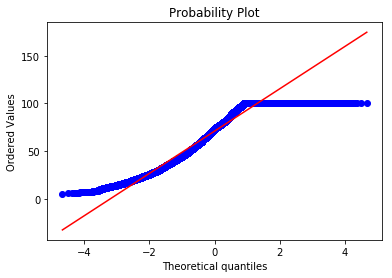

In [152]:
print(df_sds011.shape)
print('----------------')
temp = df_dht22.groupby(level=1).mean().sort_index()
print(temp.shape)
print(temp.isnull().sum())

from scipy.stats import loggamma

fig = plt.figure()
ax = fig.add_subplot(111)

print(temp['humidity'].describe())
probplot(temp['humidity'].values, plot=ax)



#np.mean(preprocessing.normalize(temp['P1'].values.reshape(1,-1))), np.std(preprocessing.normalize(temp['P1'].values.reshape(1,-1)))

# Resample and Merge

In [26]:
def resample(df, freq='60min'):
    level_values = df.index.get_level_values
    return df.groupby([level_values(0)] + [pd.Grouper(freq=freq, level=1)]).mean().dropna()

In [27]:
print(df_sds011.shape)
print(df_dht22.shape)

df_sds011 = df_sds011.groupby(level=1).mean().sort_index()
df_dht22 = df_dht22.groupby(level=1).mean().sort_index()

df_sds011 = df_sds011.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()
df_dht22 = df_dht22.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()

print(df_sds011.shape)
print(df_dht22.shape)

#print(temp.describe())
#print(temp.shape)
#temp = temp.groupby(pd.Grouper(freq='60min', level=0)).mean().dropna()
#print(temp.shape)
#print(temp.describe())


#temp = temp[temp.index < '2018-11-16']
#temp = temp[temp.humidity <= 70.0]

#bound = 70#50

#s = temp.humidity
#t = temp.index

#supper = np.ma.masked_where(s >= bound, s)
#srest = np.ma.masked_where(s < bound, s)

#fig, axes = plt.subplots(nrows=1, ncols=1)
#axes.plot(t, srest, 'red', t, supper, 'green')
    
    
#fig = plt.figure()
#ax = fig.add_subplot(111)
#probplot(temp['temperature'].values, plot=ax)


(463074, 2)
(472139, 2)
(10574, 2)
(10583, 2)


In [59]:

#df_sds011 = resample(df_sds011)
#df_dht22 = resample(df_dht22)

In [ ]:
print(df_sds011.shape, df_dht22.shape)

In [28]:
data = pd.merge(df_sds011, df_dht22, left_index=True, right_index=True, how='inner')
data = data[data.humidity <= 70.0]
print(data.isnull().sum())
print(data.shape)

P1             0
P2             0
temperature    0
humidity       0
dtype: int64
(4859, 4)


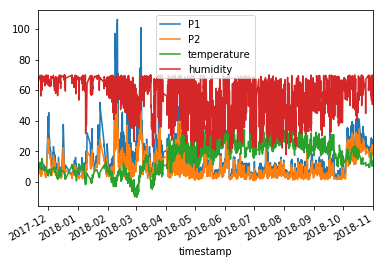

In [29]:
data = data[data.index < '2018-11-16']
data.plot()

In [ ]:

alpha = list(data.columns.values)

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()



In [ ]:
df_dht22[['temperature']].hist(bins=50, by='location')

In [ ]:
df_dht22[['humidity']].hist(bins=50, by='location')

In [ ]:
bins = int(len(range(int(df_sds011['P1'].min()), int(df_sds011['P1'].max()))) / 5 )
df_sds011[['P1']].hist(bins=bins, by='location')

In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 50

f, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

groups = list(df_sds011.groupby(level=0))


sns.distplot(groups[0][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text(groups[0][0])

sns.distplot(groups[1][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text(groups[1][0])

sns.distplot(groups[2][1][['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text(groups[2][0])


    
plt.tight_layout()
    


In [ ]:
#bins = int(len(range(int(df_sds011['P2'].min()), int(df_sds011['P2'].max()))) / 5 )
bins = 15


f, axes = plt.subplots(3, 2, figsize=(10, 7), sharex=True)

#data gets average over location 

#d = data[data['P1'] <= 15]
d = data
sns.distplot(d[['P1']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,0])

axes[0,0].title.set_text('P1')

sns.distplot(d[['P2']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0,1])

axes[0,1].title.set_text('P2')


sns.distplot(boxcox(d[['P1']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,0])

axes[1,0].title.set_text('P1 boxcox')

sns.distplot(boxcox(d[['P2']], lmbda=0), hist=False, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[1,1])

axes[1,1].title.set_text('P2 boxcox')

sns.distplot(d[['temperature']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,0])

axes[2,0].title.set_text('Temperature')

sns.distplot(d[['humidity']], hist=True, kde=True, 
             bins=bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[2,1])

axes[2,1].title.set_text('Humidity')

    
plt.tight_layout()
    

# Time Series

In [30]:

 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled





#df_sds011[['P1', 'P2']] =  preprocessing.normalize(df_sds011[['P1', 'P2']], axis=0, norm='max')
#scaler = preprocessing.StandardScaler()
#df_sds011[['P1', 'P2']] = scaler.fit_transform(df_sds011[['P1', 'P2']])

#df_dht22[['temperature', 'humidity']] = preprocessing.normalize(df_dht22[['temperature', 'humidity']], axis=0, norm='max')
#scaler = preprocessing.StandardScaler()
#df_dht22[['temperature', 'humidity']] = scaler.fit_transform(df_dht22[['temperature', 'humidity']])

In [31]:
#remove location as index, leaving only timestamp

#data = data.groupby(level=1).mean().sort_index()[['P1', 'P2', 'temperature', 'humidity']]
#data = data[['humidity', 'temperature', 'P1']]
data = data[['temperature', 'P1']]
data = series_to_supervised(data, n_in=1, n_out=1, dropnan=True)
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
timestamp,,,,
2017-11-20 10:00:00,8.091667,11.602083,9.316000,11.801600
2017-11-20 11:00:00,9.316000,11.801600,10.037500,11.670000
2017-11-20 12:00:00,10.037500,11.670000,9.708333,10.525000
2017-11-20 13:00:00,9.708333,10.525000,9.416000,9.345600
2017-11-20 14:00:00,9.416000,9.345600,8.913043,7.041818


In [32]:
data['diff2-1'] = data['var2(t)'] - data['var2(t-1)']
#data['diff2-2'] = data['var2(t)'] - data['var2(t-2)']
#data['diff2-3'] = data['var2(t)'] - data['var2(t-3)']

data['diff1-1'] = data['var1(t)'] - data['var1(t-1)']
#data['diff1-2'] = data['var1(t)'] - data['var1(t-2)']
#data['diff1-3'] = data['var1(t)'] - data['var1(t-3)']

data.head()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1
timestamp,,,,,,
2017-11-20 10:00:00,8.091667,11.602083,9.316000,11.801600,0.199517,1.224333
2017-11-20 11:00:00,9.316000,11.801600,10.037500,11.670000,-0.131600,0.721500
2017-11-20 12:00:00,10.037500,11.670000,9.708333,10.525000,-1.145000,-0.329167
2017-11-20 13:00:00,9.708333,10.525000,9.416000,9.345600,-1.179400,-0.292333
2017-11-20 14:00:00,9.416000,9.345600,8.913043,7.041818,-2.303782,-0.502957


In [33]:

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit_transform(data)
data = DataFrame(scaler, index=data.index, columns=data.columns)
data.head()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1
timestamp,,,,,,
2017-11-20 10:00:00,-0.300199,-0.803527,-0.253391,-0.799730,0.253198,-0.027957
2017-11-20 11:00:00,-0.253391,-0.799730,-0.225806,-0.802234,0.247078,-0.071830
2017-11-20 12:00:00,-0.225806,-0.802234,-0.238391,-0.824023,0.228345,-0.163503
2017-11-20 13:00:00,-0.238391,-0.824023,-0.249568,-0.846467,0.227710,-0.160289
2017-11-20 14:00:00,-0.249568,-0.846467,-0.268796,-0.890307,0.206926,-0.178666


In [34]:
data.describe()

,var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff1-1
count,4732.000000,4732.000000,4732.000000,4732.000000,4732.000000,4732.000000
mean,0.064947,-0.787126,0.064967,-0.787065,0.249569,-0.134738
std,0.408013,0.240237,0.407998,0.240269,0.060945,0.175570
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.247591,-0.925263,-0.246993,-0.925263,0.235013,-0.201588
50%,0.162982,-0.873734,0.162982,-0.873734,0.249602,-0.162561
75%,0.374889,-0.753248,0.374889,-0.753195,0.265079,-0.106403
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
def create_model(batch_size, stateful=True):
    if batch_size:
        inp = Input(batch_shape=(batch_size,1,X_train.shape[-1]))
    else:
        inp = Input(shape=(1,X_train.shape[-1],))
    x = GRU(20, stateful=stateful, return_sequences=False)(inp)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='sigmoid')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    model = Model(inp, x)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_data(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    y_train = train[['var2(t)']].values
    X_train = train.drop(columns=['var2(t)']).values

    X_test = test.drop(columns=['var2(t)']).values
    y_test = test[['var2(t)']].values

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_train, X_test, y_train, y_test

def predict_baseline(train, test):
    """
    Train and Test parameters are pandas DataFrames.
    """
    ### Persistence Baseline
    baseline = mean_squared_error(test['var2(t-1)'].values, test['var2(t)'].values)
    print('Persistence Baseline %.5f' % baseline)
    return baseline, test[['var2(t-1)', 'var2(t)']]


def train_normal(X_train, X_test, y_train, y_test):
    model = create_model(None, stateful=False)
    model.fit(X_train, y_train, epochs=10000, shuffle=True, batch_size=len(X_train), validation_data=(X_test, y_test), callbacks=[TQDMNotebookCallback(leave_inner=False, leave_outer=True, show_inner=False)], verbose=0)
    return model, model

def train_timeseries(X_train, X_test, y_train, y_test):
    train_model = create_model(len(X_train))
    test_model = create_model(len(X_test))

    pbar = tqdm(range(10000), leave=True)

    for i in pbar:
        train_model.fit(X_train, y_train, epochs=1, shuffle=False, batch_size=len(X_train), verbose=0)
        train_model.reset_states()

        test_model.set_weights(train_model.get_weights())
        r = test_model.evaluate(X_test, y_test, batch_size=len(X_test), verbose=0)
        pbar.set_description("Test: %.5f" % r)
    return train_model, test_model

def predict(X_train, X_test, y_train, y_test, train_fn):

    result = {}

    train_model, test_model = train_fn(X_train, X_test, y_train, y_test)

    pred = test_model.predict(X_test, batch_size=len(X_test))
    mse = mean_squared_error(pred.reshape(pred.shape[0]),  y_test)
        
    df = pd.DataFrame(index=test.index)
    df['pred'] = pred.reshape(pred.shape[0])
    df['true'] = y_test
    
    
    return mse, df, train_model, test_model


def plot_eval(df, test):
    test[['var2(t-1)', 'var2(t)']].plot(figsize=(25,5))
    df.plot(figsize=(25,5))


kfold = KFold(3, shuffle=False, random_state=SEED)

results_ts = []
results_norm = []
for train, test in kfold.split(data):
    train, test = data.iloc[train], data.iloc[test]
    baseline, baseline_df = predict_baseline(train, test)
    
    X_train, X_test, y_train, y_test = create_data(train, test)
    
    mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_timeseries)
    results_ts.append((baseline, mse, baseline_df, df, train_model, test_model, test))
    
    mse, df, train_model, test_model = predict(X_train, X_test, y_train, y_test, train_timeseries)
    results_norm.append((baseline, mse, baseline_df, df, train_model, test_model, test))
    
results = np.asarray(results)

print('Baseline mse %.5f (%.5f STD)' % (np.mean(results[:,0]), np.std(results[:,0])))
print('Model mse %.5f (%.5f STD)' % (np.mean(results[:,1]), np.std(results[:,1])))

Persistence Baseline 0.00802


Persistence Baseline 0.00163


Persistence Baseline 0.00216


Baseline mse 0.00393 (0.00289 STD)
Model mse 0.00964 (0.01224 STD)


In [94]:
print(results[:,0])
print(results[:,1])

[0.008015545451500962 0.0016309769254212068 0.0021581371543381877]
[0.028698832787050967 5.286978970272551e-05 0.00010829172715444372]


In [97]:
print(results[:,0])
print(results[:,1])

[0.008015545451500962 0.0016309769254212068 0.0021581371543381877]
[0.026941237219173585 0.00044094464666759694 0.001545467930968512]


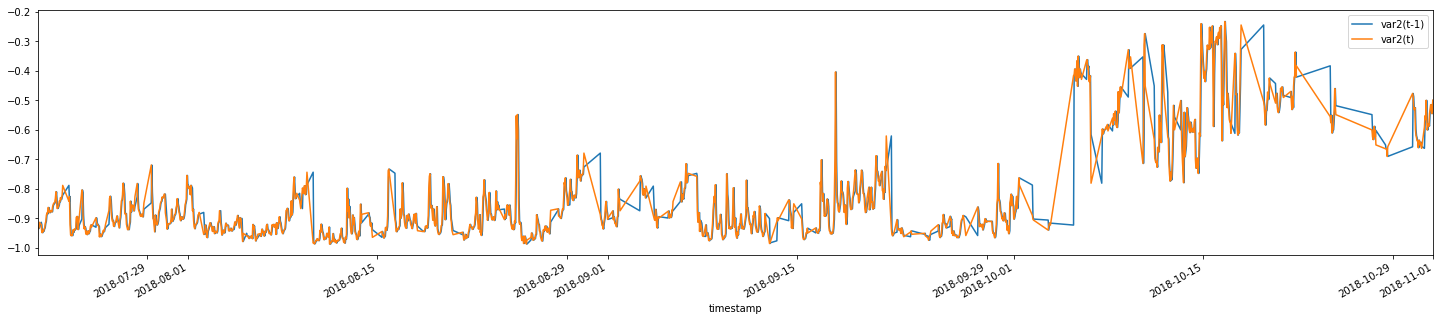

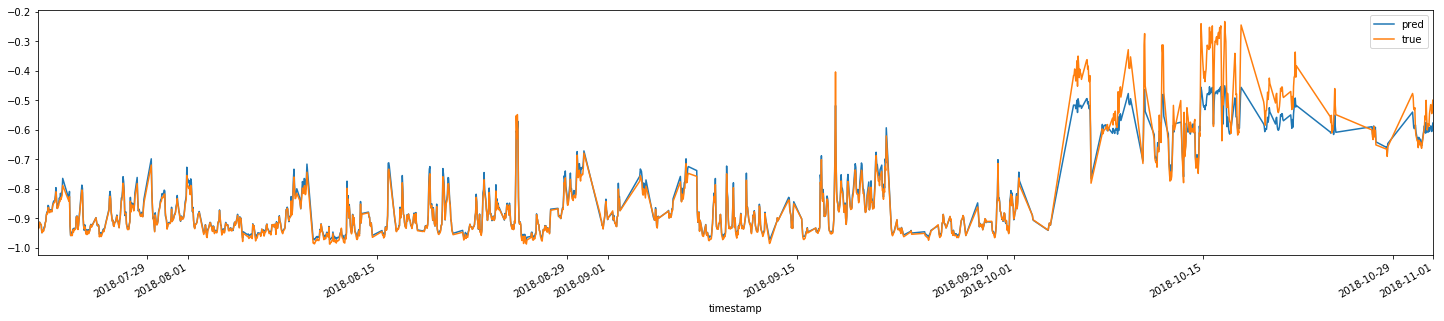

In [100]:
plot_eval(results[2][3], results[2][-1])

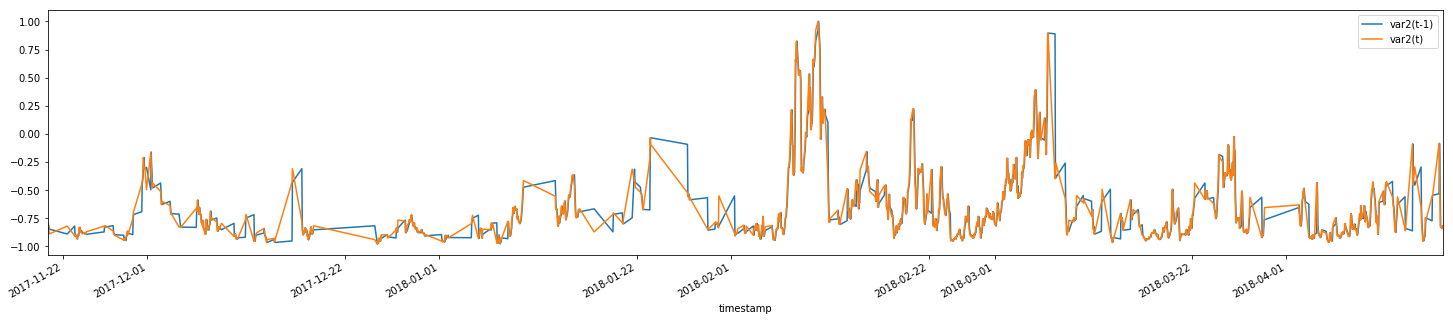

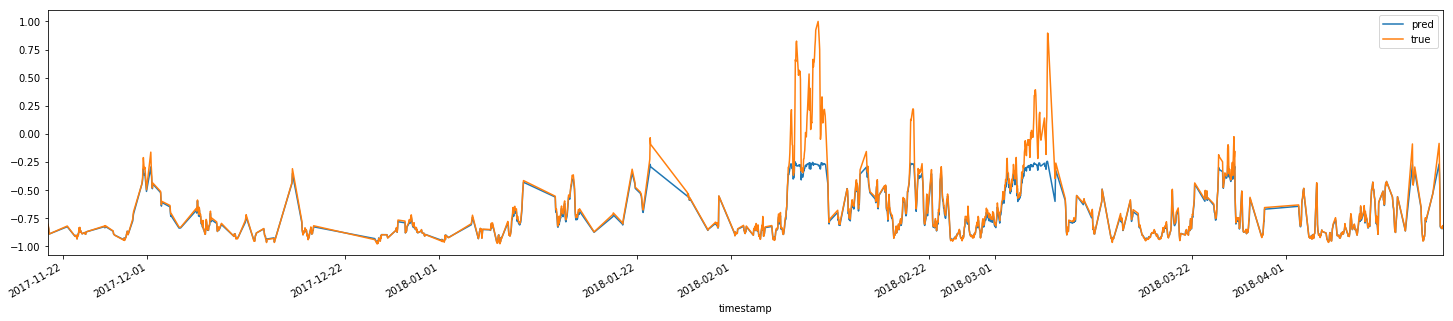

In [92]:
plot_eval(results[0][3], results[0][-1])

In [ ]:
#0.0015475065379159923 t = 1
#0.0024574477420651925 t = 2
#0.016846461474702874 t = 3
#0.03757798906665827 t = 1 ohne sigmoid + dropout layer

In [385]:
data.describe()

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t),diff2-1,diff2-2,diff1-1,diff1-2
count,4731.000000,4731.000000,4731.000000,4731.000000,4731.000000,4731.000000,4731.000000,4731.000000,4731.000000,4731.000000
mean,0.065003,-0.787187,0.065025,-0.787122,0.065034,-0.787062,0.249569,0.265731,-0.134761,-0.237931
std,0.408038,0.240226,0.408021,0.240262,0.408014,0.240295,0.060951,0.090363,0.175582,0.199461
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.247710,-0.925275,-0.247153,-0.925275,-0.246675,-0.925275,0.235011,0.241132,-0.201603,-0.332264
50%,0.162986,-0.873738,0.162986,-0.873738,0.162986,-0.873738,0.249602,0.266651,-0.162562,-0.278999
75%,0.374950,-0.753321,0.374950,-0.753238,0.374950,-0.753173,0.265081,0.290252,-0.106426,-0.192776
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Check for Random Walk, Stationarity ...

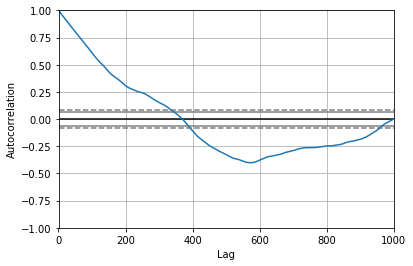

In [345]:


seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
#pyplot.plot(random_walk)
autocorrelation_plot(random_walk)
pyplot.show()

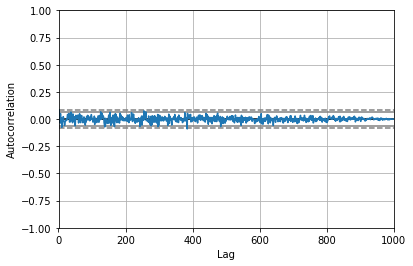

In [347]:

series = [randrange(10) for i in range(1000)]
autocorrelation_plot(series)


In [371]:

# statistical test
result = adfuller(d['temperature'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.633108
p-value: 0.086346
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


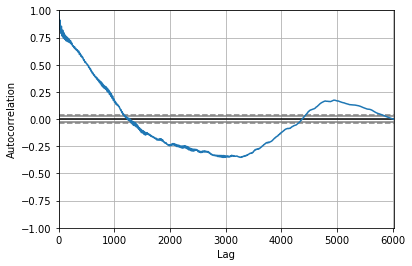

In [370]:
autocorrelation_plot(d['temperature'])

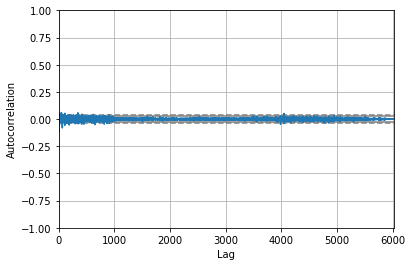

In [367]:
values = []
for t in range(1, len(d['P1'])):
    value = d['P1'].values[t] - d['P1'].values[t - 1]
    values.append(value)

#pyplot.plot(values)
#pyplot.show()
autocorrelation_plot(values)